# Entrega 5 CNN

Primero vamos a comprobar que tenemos GPU disponible

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14365033412861325021
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3300982784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15745948337595215392
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Ahora vamos a cargar el dataset, en esta caso CIFAR10. Este contiene 50000 imágenes a color de 32x32 para el entrenamiento y 10000 para el test, divididas en 10 categorias.

In [16]:
import tensorflow.keras
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


Vemos una de las imagenes y su categoría

truck


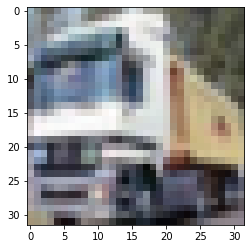

In [17]:
import matplotlib.pyplot as plt

# Creamos las categorias para poder interpretar los resultados
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow(x_train[1])
print(class_names[y_train[1][0]])

Preparamos los datos usando generadores que nos permiten hacer data augmentation y normalización. Además separamos un 20% de los datos de train para validación.

In [18]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Se normalizan las imagenes. Cada canal del pixel entre 0. y 1.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# Creamos el One Hot para las clases
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(x_train, y_train, batch_size=32, subset='training')

validation_generator = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

test_generator = ImageDataGenerator(rescale=1./255).flow(x_test, y_test, batch_size=32)

Creamos el modelo que tiene varias capas convolucionales además de algunas de dropout para paliar el overfiting

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

opt = optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)         

Entrenamos el modelo

In [20]:
batch_size = 64
num_epoch = 200

model_log = model.fit(train_generator,
          epochs=num_epoch,
          verbose=1,
          validation_data=validation_generator)

Epoch 1/200
1250/1250 [==============================] - 28s 19ms/step - loss: 2.1428 - accuracy: 0.2027 - val_loss: 1.7736 - val_accuracy: 0.3488
Epoch 2/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7635 - accuracy: 0.3516 - val_loss: 1.6622 - val_accuracy: 0.3850
Epoch 3/200
1250/1250 [==============================] - 22s 18ms/step - loss: 1.6302 - accuracy: 0.4036 - val_loss: 1.5570 - val_accuracy: 0.4283
Epoch 4/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5614 - accuracy: 0.4308 - val_loss: 1.4925 - val_accuracy: 0.4524
Epoch 5/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.5122 - accuracy: 0.4493 - val_loss: 1.4653 - val_accuracy: 0.4690
Epoch 6/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4598 - accuracy: 0.4694 - val_loss: 1.4297 - val_accuracy: 0.4832
Epoch 7/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4088 - accuracy: 0.4892 - val_loss: 1

1250/1250 [==============================] - 20s 16ms/step - loss: 0.6264 - accuracy: 0.7801 - val_loss: 0.6350 - val_accuracy: 0.7808
Epoch 112/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6294 - accuracy: 0.7811 - val_loss: 0.6317 - val_accuracy: 0.7770
Epoch 113/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6371 - accuracy: 0.7775 - val_loss: 0.6406 - val_accuracy: 0.7767
Epoch 114/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6421 - accuracy: 0.7717 - val_loss: 0.6573 - val_accuracy: 0.7691
Epoch 115/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6343 - accuracy: 0.7776 - val_loss: 0.6510 - val_accuracy: 0.7780
Epoch 116/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6423 - accuracy: 0.7772 - val_loss: 0.6207 - val_accuracy: 0.7862
Epoch 117/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6198 - accuracy: 0.7817 - val_loss: 0

1250/1250 [==============================] - 20s 16ms/step - loss: 0.5697 - accuracy: 0.8014 - val_loss: 0.5954 - val_accuracy: 0.7951
Epoch 167/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5517 - accuracy: 0.8050 - val_loss: 0.5930 - val_accuracy: 0.7936
Epoch 168/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5613 - accuracy: 0.8038 - val_loss: 0.6126 - val_accuracy: 0.7859
Epoch 169/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.5634 - accuracy: 0.8025 - val_loss: 0.6121 - val_accuracy: 0.7912
Epoch 170/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5585 - accuracy: 0.8049 - val_loss: 0.5980 - val_accuracy: 0.7885
Epoch 171/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5626 - accuracy: 0.8023 - val_loss: 0.5851 - val_accuracy: 0.7974
Epoch 172/200
1250/1250 [==============================] - 21s 16ms/step - loss: 0.5564 - accuracy: 0.8060 - val_loss: 0

Visualizamos los datos del entrenamiento con su validación

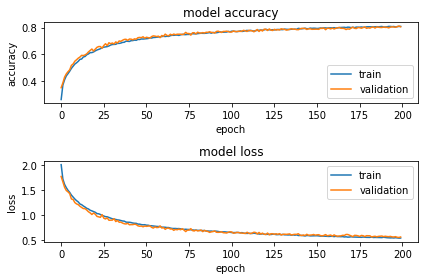

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

Evaluamos el modelo con los datos del test y visualizamos los resultados obtenidos

In [22]:
results = model.evaluate(test_generator, verbose=1)
print("Test loss:", results[0], "Test accuracy:", results[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.5256 - accuracy: 0.8266
Test loss: 0.5255857706069946 Test accuracy: 0.8266000151634216


Por último guardamos el modelo en disco así como los pesos entrenados

In [23]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("modelCNN1_digit.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("modelCNN1_digit.h5")
print("Saved model to disk")

Saved model to disk
